Reference: https://www.kaggle.com/underwearfitting/pytorch-densenet-arcface-validation-training

## Imports

In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')
import os
import sys
import time
import cv2
import PIL.Image
import random
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
import albumentations  # for image transformation
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import gc
from sklearn.metrics import roc_auc_score
%matplotlib inline
import seaborn as sns
from pylab import rcParams
import timm  # for pretrained backbone model
from warnings import filterwarnings
from sklearn.preprocessing import LabelEncoder
import math
import glob
from sklearn.model_selection import StratifiedKFold, GroupKFold
filterwarnings("ignore")

device = torch.device('cuda')

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False # set True to be faster
    print(f'Setting all seeds to be {seed} to reproduce...')
seed_everything(42)

Setting all seeds to be 42 to reproduce...


## Configuration

In [3]:
image_size = 512
batch_size = 16
n_worker = 4
init_lr = 3e-4
n_epochs = 6 # from my experiments, use > 25 when margin = 0.5
fold_id = 0
holdout_id = 0
valid_every = 5
save_after = 10
margin = 0.5 # 0 for faster convergence, larger may be beneficial
search_space = np.arange(40, 100, 10) # in my experiments, thresholds should be between 40 - 90 (/100) for cosine similarity
use_amp = False # todo: figure how to work with pytorch native amp
debug = True # set this to False to train in full
kernel_type = 'baseline'
model_dir = './weights/'
data_dir = '../input/shopee-product-matching/train_images'
! mkdir $model_dir

## Make Folds

In [4]:
df_train = pd.read_csv('../input/shopee-product-matching/train.csv')
df_train['file_path'] = df_train.image.apply(lambda x: os.path.join(data_dir, x))
df_train.head(5)

,posting_id,image,image_phash,title,label_group,file_path
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,../input/shopee-product-matching/train_images/...
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,../input/shopee-product-matching/train_images/...
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,../input/shopee-product-matching/train_images/...
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188,../input/shopee-product-matching/train_images/...
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069,../input/shopee-product-matching/train_images/...


In [5]:
gkf = GroupKFold(n_splits=5)
df_train['fold'] = -1
for fold, (train_idx, valid_idx) in enumerate(gkf.split(df_train, None, df_train.label_group)):
    df_train.loc[valid_idx, 'fold'] = fold

In [6]:
le = LabelEncoder()
df_train.label_group = le.fit_transform(df_train.label_group)

## Transforms

In [7]:
transforms_train = albumentations.Compose([
    albumentations.Resize(image_size, image_size),
    albumentations.HorizontalFlip(p=0.5),
    albumentations.RandomBrightnessContrast(p=0.5, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2)),
    albumentations.HueSaturationValue(p=0.5, hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2),
    albumentations.ShiftScaleRotate(p=0.5, shift_limit=0.0625, scale_limit=0.2, rotate_limit=20),
    albumentations.CoarseDropout(p=0.5),
    albumentations.Normalize()
])

transforms_valid = albumentations.Compose([
    albumentations.Resize(image_size, image_size),
    albumentations.Normalize()
])

## Dataset

In [8]:
class SHOPEEDataset(Dataset):
    def __init__(self, df, mode, transform=None):
        
        self.df = df.reset_index(drop=True)
        self.mode = mode
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        row = self.df.loc[index]
        img = cv2.imread(row.file_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if self.transform is not None:
            res = self.transform(image=img)
            img = res['image']
                
        img = img.astype(np.float32)
        img = img.transpose(2,0,1)
        
        if self.mode == 'test':
            return torch.tensor(img).float()
        else:
            return torch.tensor(img).float(), torch.tensor(row.label_group).float()

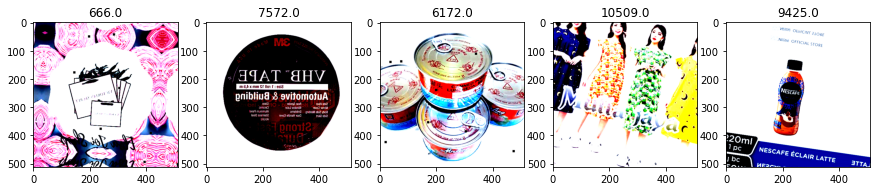

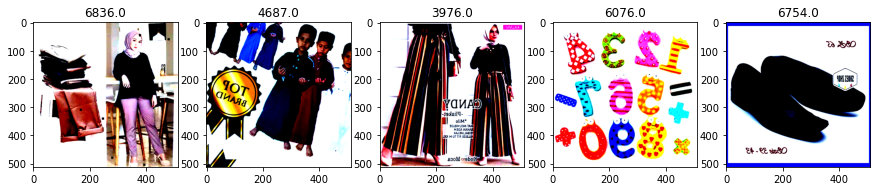

In [9]:
dataset = SHOPEEDataset(df_train, 'train', transform = transforms_train)
rcParams['figure.figsize'] = 15,5
for i in range(2):
    f, axarr = plt.subplots(1,5)
    for p in range(5):
        idx = i*5 + p
        img, label = dataset[idx]
        axarr[p].imshow(img.transpose(0,1).transpose(1,2).squeeze())
        axarr[p].set_title(label.item())

## Model

In [10]:
class ArcModule(nn.Module):
    def __init__(self, in_features, out_features, s = 10, m = margin):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_normal_(self.weight)

        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = torch.tensor(math.cos(math.pi - m))
        self.mm = torch.tensor(math.sin(math.pi - m) * m)

    def forward(self, inputs, labels):
        cos_th = F.linear(inputs, F.normalize(self.weight))
        cos_th = cos_th.clamp(-1, 1)
        sin_th = torch.sqrt(1.0 - torch.pow(cos_th, 2))
        cos_th_m = cos_th * self.cos_m - sin_th * self.sin_m
        # print(type(cos_th), type(self.th), type(cos_th_m), type(self.mm))
        cos_th_m = torch.where(cos_th > self.th, cos_th_m, cos_th - self.mm)

        cond_v = cos_th - self.th
        cond = cond_v <= 0
        cos_th_m[cond] = (cos_th - self.mm)[cond]

        if labels.dim() == 1:
            labels = labels.unsqueeze(-1)
        onehot = torch.zeros(cos_th.size()).cuda()
        labels = labels.type(torch.LongTensor).cuda()
        onehot.scatter_(1, labels, 1.0)
        outputs = onehot * cos_th_m + (1.0 - onehot) * cos_th
        outputs = outputs * self.s
        return outputs

In [11]:
class SHOPEEDenseNet(nn.Module):

    def __init__(self, channel_size, out_feature, dropout=0.5, backbone='densenet121', pretrained=True):
        super(SHOPEEDenseNet, self).__init__()
        self.backbone = timm.create_model(backbone, pretrained=pretrained)
        self.channel_size = channel_size
        self.out_feature = out_feature
        self.in_features = self.backbone.classifier.in_features
        self.margin = ArcModule(in_features=self.channel_size, out_features = self.out_feature)
        self.bn1 = nn.BatchNorm2d(self.in_features)
        self.dropout = nn.Dropout2d(dropout, inplace=True)
        self.fc1 = nn.Linear(self.in_features * 16 * 16 , self.channel_size)
        self.bn2 = nn.BatchNorm1d(self.channel_size)
        
    def forward(self, x, labels=None):
        features = self.backbone.features(x)
        features = self.bn1(features)
        features = self.dropout(features)
        features = features.view(features.size(0), -1)
        features = self.fc1(features)
        features = self.bn2(features)
        features = F.normalize(features)
        if labels is not None:
            return self.margin(features, labels)
        return features

In [12]:
model = SHOPEEDenseNet(512, df_train.label_group.nunique())
model.to(device);

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/densenet121_ra-50efcf5c.pth" to /root/.cache/torch/hub/checkpoints/densenet121_ra-50efcf5c.pth


## Utils

In [13]:
def train_func(train_loader):
    model.train()
    bar = tqdm(train_loader)
    if use_amp:
        scaler = torch.cuda.amp.GradScaler()
    losses = []
    for batch_idx, (images, targets) in enumerate(bar):

        images, targets = images.to(device), targets.to(device).long()
        
        if debug and batch_idx == 100:
            print('Debug Mode. Only train on first 100 batches.')
            break
            
        if use_amp:
            with torch.cuda.amp.autocast():
                logits = model(images, targets)
                loss = criterion(logits, targets)
            scaler.scale(loss).backward()
            if ((batch_idx + 1) %  accumulation_step == 0) or ((batch_idx + 1) == len(train_loader)):
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
        else:
            logits = model(images, targets)
            loss = criterion(logits, targets)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        losses.append(loss.item())
        smooth_loss = np.mean(losses[-30:])

        bar.set_description(f'loss: {loss.item():.5f}, smth: {smooth_loss:.5f}')

    loss_train = np.mean(losses)
    return loss_train


def valid_func(valid_loader):
    model.eval()
    bar = tqdm(valid_loader)

    PROB = []
    TARGETS = []
    losses = []
    PREDS = []

    with torch.no_grad():
        for batch_idx, (images, targets) in enumerate(bar):

            images, targets = images.to(device), targets.to(device).long()

            logits = model(images, targets)

            PREDS += [torch.argmax(logits, 1).detach().cpu()]
            TARGETS += [targets.detach().cpu()]

            loss = criterion(logits, targets)
            losses.append(loss.item())
           
            bar.set_description(f'loss: {loss.item():.5f}')

    PREDS = torch.cat(PREDS).cpu().numpy()
    TARGETS = torch.cat(TARGETS).cpu().numpy()
    accuracy = (PREDS==TARGETS).mean()
   
    loss_valid = np.mean(losses)
    return loss_valid, accuracy

def generate_test_features(test_loader):
    model.eval()
    bar = tqdm(test_loader)
    
    FEAS = []
    TARGETS = []

    with torch.no_grad():
        for batch_idx, (images) in enumerate(bar):

            images = images.to(device)

            features = model(images)

            FEAS += [features.detach().cpu()]

    FEAS = torch.cat(FEAS).cpu().numpy()
    
    return FEAS

In [14]:
def row_wise_f1_score(labels, preds):
    scores = []
    for label, pred in zip(labels, preds):
        n = len(np.intersect1d(label, pred))
        score = 2 * n / (len(label)+len(pred))
        scores.append(score)
    return scores, np.mean(scores)

In [15]:
def find_threshold(df, lower_count_thresh, upper_count_thresh, search_space):
    '''
    Compute the optimal threshold for the given count threshold.
    '''
    score_by_threshold = []
    best_score = 0
    best_threshold = -1
    for i in tqdm(search_space):
        sim_thresh = i/100
        selection = ((FEAS@FEAS.T) > sim_thresh).cpu().numpy()
        matches = []
        oof = []
        for row in selection:
            oof.append(df.iloc[row].posting_id.tolist())
            matches.append(' '.join(df.iloc[row].posting_id.tolist()))
        tmp = df.groupby('label_group').posting_id.agg('unique').to_dict()
        df['target'] = df.label_group.map(tmp)
        scores, score = row_wise_f1_score(df.target, oof)
        df['score'] = scores
        df['oof'] = oof
        
        selected_score = df.query(f'count > {lower_count_thresh} and count < {upper_count_thresh}').score.mean()
        score_by_threshold.append(selected_score)
        if selected_score > best_score:
            best_score = selected_score
            best_threshold = i
            
    plt.title(f'Threshold Finder for count in [{lower_count_thresh},{upper_count_thresh}].')
    plt.plot(score_by_threshold)
    plt.axis('off')
    plt.show()
    print(f'Best score is {best_score} and best threshold is {best_threshold/100}')

## Train

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = init_lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs)

In [17]:
df_train_this = df_train[df_train['fold'] != fold_id]
df_valid_this = df_train[df_train['fold'] == fold_id]

df_valid_this['count'] = df_valid_this.label_group.map(df_valid_this.label_group.value_counts().to_dict())

dataset_train = SHOPEEDataset(df_train_this, 'train', transform = transforms_train)
dataset_valid = SHOPEEDataset(df_valid_this, 'test', transform = transforms_valid)

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers = n_worker)
valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False, num_workers = n_worker)

  0%|          | 0/1713 [00:00<?, ?it/s]

Debug Mode. Only train on first 100 batches.
Now generating features for the validation set to simulate the submission.


  0%|          | 0/429 [00:00<?, ?it/s]

Finding Best Threshold in the given search space.


  0%|          | 0/6 [00:00<?, ?it/s]

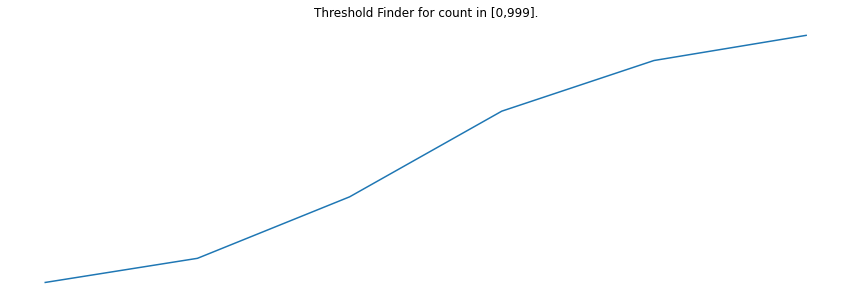

Best score is 0.5328701311393456 and best threshold is 0.9


  0%|          | 0/1713 [00:00<?, ?it/s]

Debug Mode. Only train on first 100 batches.


  0%|          | 0/1713 [00:00<?, ?it/s]

Debug Mode. Only train on first 100 batches.


  0%|          | 0/1713 [00:00<?, ?it/s]

Debug Mode. Only train on first 100 batches.


  0%|          | 0/1713 [00:00<?, ?it/s]

Debug Mode. Only train on first 100 batches.


  0%|          | 0/1713 [00:00<?, ?it/s]

Debug Mode. Only train on first 100 batches.
Now generating features for the validation set to simulate the submission.


  0%|          | 0/429 [00:00<?, ?it/s]

Finding Best Threshold in the given search space.


  0%|          | 0/6 [00:00<?, ?it/s]

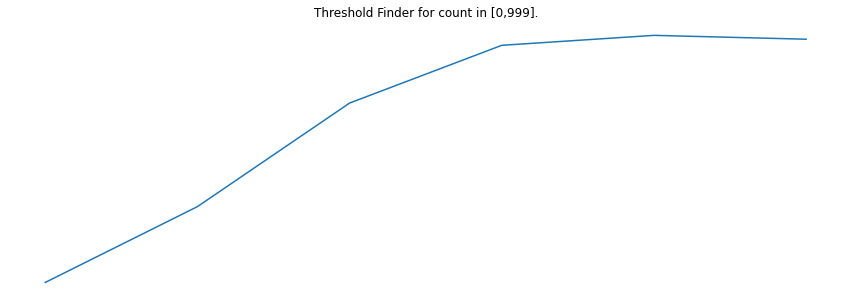

Best score is 0.5845974900316533 and best threshold is 0.8


In [18]:
for epoch in range(n_epochs):
    scheduler.step()
    loss_train = train_func(train_loader)
    if epoch % valid_every == 0: 
        print('Now generating features for the validation set to simulate the submission.')
        FEAS = generate_test_features(valid_loader)
        FEAS = torch.tensor(FEAS).cuda()
        print('Finding Best Threshold in the given search space.')
        find_threshold(df = df_valid_this, 
               lower_count_thresh = 0, 
               upper_count_thresh = 999,
               search_space = search_space)
        if epoch >= save_after:
            torch.save(model.state_dict(), f'{model_dir}{kernel_type}_fold{fold_id}_densenet_{image_size}_epoch{epoch}.pth')

In [19]:
df_valid_this.head()

,posting_id,image,image_phash,title,label_group,file_path,fold,count,target,score,oof
6,train_1802986387,00144a49c56599d45354a1c28104c039.jpg,f815c9bb833ab4c8,Jubah anak size 1-12 thn,4687,../input/shopee-product-matching/train_images/...,0,7,"[train_1802986387, train_1396161074, train_713...",0.250000,[train_1802986387]
10,train_1598329973,001d7f5d9a2fac714f4d5f37b3baffb4.jpg,bec8d09693634b4b,Atasan Rajut Wanita LISDIA SWEATER,6347,../input/shopee-product-matching/train_images/...,0,3,"[train_1598329973, train_841015183, train_4224...",0.500000,[train_1598329973]
15,train_4196427721,002039aaf8618627a0442d5e89e5dda6.jpg,e98c873acc65946e,Korek Kuping LED untuk balita CherryBabyKidsSh...,897,../input/shopee-product-matching/train_images/...,0,8,"[train_4196427721, train_1482447822, train_234...",0.545455,"[train_4196427721, train_2221959828, train_375..."
18,train_2985955659,002f978c58a44a00aadfca71c3cad2bb.jpg,bf38f0e083d7c710,HnKfashion Sweater Hoodie WHO Printing BabyTer...,8795,../input/shopee-product-matching/train_images/...,0,3,"[train_2985955659, train_3916258742, train_415...",1.000000,"[train_2985955659, train_3916258742, train_415..."
27,train_3466601092,004076b57135e761ab8b41d84acc4c94.jpg,aa2c0ee4eb6ba0cd,[Shiyan] mainan gigitan bayi set pack baby tee...,7555,../input/shopee-product-matching/train_images/...,0,2,"[train_3466601092, train_354147588]",1.000000,"[train_3466601092, train_354147588]"
